# Data mining Toronto Fire Incidents Final Report

## Abstract
---
## Objectives
The pipeline achieves the following:

- `Pipeline`
  - `Data_Preprocessing`
    - `Data_cleaning (Ryan)`
      - Drops columns with no relevance.
      - Sanitizes descrepancies for manual input data.
      - Replaces empty strings in categorical columns with `pd.NA`.
      - Drops rows with no values at all according to feature: `Area_of_Origin`.
      - Removes false positives, according to feature: `Final_Incident_Type`
      - Converts non-null values of categorical columns to string to ensure data integrity, ease the imputation processs.
      - Removes outliers using z-score method to eliminate rows that 3 standard deviations from the mean, based on feature, `Estimated_Dollar_Loss`.
      - Replaces values of `NAType` with `np.nan` for numerical columns.
    - `Feature_Engineering` 
      - creates a new feature `Control_Time`. (How long fire burned for.)
      - creates a new feature called `Response_Time`. (How long took for the first arriving unit to get to the incident)
    - `feature_transformers (Ryan)`
      - Applies simple imputer to all categorical features.
      - Applies KNN imputer to all numerical features.
      - Applies ordinal encoding to all categorical features.
      - Standard scale all numerical features.
      - Applies log transformation on response variable.
    - `Feature Selection (Ryan)`
      - Drops features with low Spearman correlation coefficients to response variable.
      - Drops categorical features with low Kruskal-Wallis H-test statistic to response variable.
      - Drops categorical features with low Chi-Squared test statistic to response variable.
      - Removes 4 worst features using `SelectKBest` method with an ANOVA F-test.
  - `model(regressor)` 
    - Linear models
      - Multiple Linear Regression (OLS - Ordinary Least Squares): `(Maurilio)`
      - Lasso (Least Absolute Shrinkage and Selection Operator): `(Maurilio)`
      - Elastic-Net: `(Maurilio)`
      - Huber Regressor:
    - Ensemble methods
      - XGBoost Regressor
    - Non-Linear Models
      - Neural networks (MLP - Multi-layer Perceptron):

### Custom Modules Developed
- data_clean.py

  Classes:
  
  - `DataCleaner`:
  
    **Functions**:
    - `cleanse_dataframe(df)`: Returns a cleansed dataframe.
    

- data_reduction.py

  Classes:
  
  - `FeatureAnalysis`:
  
    **Functions**:
    
    - `keepStrongestFeaturesInDataFrame(responseVariable, df, p_value, correlation)`: Returns a dataframe with features that have a strong correlation and statistical significance to `responseVariable`.
---

## Data Analysis and Visualization
See `src/ExpDataAnalysis.ipynb` and `src/proposal/hypothesis_testing.ipynb`

## Data Preprocessing Pipeline

In [1]:
# Third Party libraries
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

from sklearn.linear_model import LinearRegression

In [2]:
# Load DF
df = pd.read_csv('../../data/raw/Fire_Incidents_Data.csv', low_memory=False)

In [3]:
# Feature Engineering before removing columns

df['Fire_Under_Control_Time'] = pd.to_datetime(df['Fire_Under_Control_Time'])
df['TFS_Alarm_Time'] = pd.to_datetime(df['TFS_Alarm_Time'])
df['TFS_Arrival_Time'] = pd.to_datetime(df['TFS_Arrival_Time'])

df['Control_Time'] = (df['Fire_Under_Control_Time'] - df['TFS_Alarm_Time']).dt.total_seconds()
df['Response_Time'] = (df['TFS_Arrival_Time'] - df['TFS_Alarm_Time']).dt.total_seconds()

### Cleanse dataframe.
See modules/data_clean.py, or `Data_Cleaning` section of Pipeline Objectives for more details.

In [4]:
# Import custom Data_cleaning module
from modules.data_clean import DataCleaner

# Cleanse Dataframe
df = DataCleaner.cleanse_dataframe(df)

### Defining all features.
- Numerical Columns
- Categorial Columns
    - Ordinal Columns
    - Onehot Columns

In [5]:
NUMERICAL_COLS = [
    "Civilian_Casualties",
    "Count_of_Persons_Rescued",
    "Estimated_Dollar_Loss",
    "Estimated_Number_Of_Persons_Displaced",
    "Number_of_responding_apparatus",
    "Number_of_responding_personnel",
    "TFS_Firefighter_Casualties",
    "Control_Time", 
    "Response_Time"
]

CATEGORICAL_COLS = ['Area_of_Origin', 'Building_Status', 'Business_Impact', 'Extent_Of_Fire', 'Final_Incident_Type', 
                'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence', 
                'Ignition_Source', 'Initial_CAD_Event_Type', 'Material_First_Ignited', 'Method_Of_Fire_Control', 
                'Possible_Cause', 'Property_Use', 'Smoke_Alarm_at_Fire_Origin', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure', 
                'Smoke_Alarm_at_Fire_Origin_Alarm_Type', 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation', 
                'Smoke_Spread', 'Sprinkler_System_Operation', 'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival', 'Incident_Ward']

# ['Business_Impact', 'Extent_Of_Fire', 'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival']
ORDINAL_COLS = CATEGORICAL_COLS[2:4] + CATEGORICAL_COLS[20:22]

# Everything else.
ONEHOT_COLS = list(set(CATEGORICAL_COLS) - set(ORDINAL_COLS))

### Imputation

#### Categorical Imputation

A SimpleImputer is applied to all `CATEGORICAL_COLS`, as it can work with string data types.

In [6]:
# Specify pd.NA as the missing value indicator for SimpleImputer
import numpy as np

imputer = SimpleImputer(strategy='most_frequent', missing_values=pd.NA)

# Apply the imputer to the categorical columns
df[CATEGORICAL_COLS] = imputer.fit_transform(df[CATEGORICAL_COLS])

#### Numerical imputation.

A KNN imputer is applied to all `NUMERICAL_COLS` missing data.

In [7]:
import numpy as np

# Replace pd.NA with np.nan
# KNNImputer does not directly support pd.NA
df = df.replace(pd.NA, np.nan)

imputer = KNNImputer()

# Apply the imputer to the categorical columns
df[NUMERICAL_COLS] = imputer.fit_transform(df[NUMERICAL_COLS])

### Categorical Encoding

This will encode all `CATEGORICAL_COLS`.

In [8]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import numpy as np

# Specify ordinal encoder
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)

# Apply the encoder to specified columns
df[CATEGORICAL_COLS] = ordinal_encoder.fit_transform(df[CATEGORICAL_COLS])

### Standard scaler on numerical Data

Apply standard scaling to all `NUMERICAL_COLS`.
Standardizes features by removing the mean and scaling to unit variance to create a normal distribution.
Many models may assume normally distributed data.

In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the DataFrame
df[NUMERICAL_COLS] = scaler.fit_transform(df[NUMERICAL_COLS])

### Log transform response variable.
Log transform the `responseVariable`, to improve heteroskedasticity (make the residual variance appear more constant) and normality (reduce the skewness of the data). 

In [11]:
# Log transform the Estimated_Dollar_Loss column
df['Estimated_Dollar_Loss'] = np.log(df['Estimated_Dollar_Loss'] + 1)  # Adding 1 to avoid log(0) issue

### Feature Selection (Part 1)
Select features based on the following:
- Spearman correlation coefficients with p-values for each categorical feature.
- Kruskal-Wallis H-test statistic for each categorical feature
- Calculate Chi-Squared test statistic for each categorical feature

Using these values, a measure of `p-value` and `correlation` is developed for each column against the response variable.

Columns are kept so long as its `(['P-value'] < 0.1) & (['Correlation'] > 0.003)`.

This will drop the following features: {'Final_Incident_Type', 'Smoke_Alarm_at_Fire_Origin'}. Increasing the correlation threshold any more will drop more features and will result in a worse r-sq.

In [12]:
# Import Data_reduction module
from modules.data_reduction import FeatureAnalysis

# helper function that will drop low correlated variables in the dataset
df_reduced = FeatureAnalysis.keepStrongestFeaturesInDataFrame('Estimated_Dollar_Loss', df, 0.1, 0.003)

### Train test split

In [13]:
from sklearn.model_selection import train_test_split
df = df_reduced
# List all columns in the DataFrame
all_columns = df.columns.tolist()

# Use every other column in the df except for the response variable
features = [col for col in all_columns if col != 'Estimated_Dollar_Loss']

# Separate features from response variable
X, y = df[features], df['Estimated_Dollar_Loss']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12)

### Feature Selection (Part 2)

Perform feature selection using the SelectKBest method from with an ANOVA F-test (f_classif). It then removes the worst four features from both the training and testing sets.

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif

# Perform feature selection using SelectKBest with ANOVA F-test
k_best_features = SelectKBest(score_func=f_classif, k=X_train.shape[1]) # Select all features initially
X_train_selected = k_best_features.fit_transform(X_train, y_train)

# Get the scores and indices of the features
feature_scores = k_best_features.scores_

# Get a list of indexes based on the value of the index's element. Sorted.
# The list of indexes is generated by the range function. (len(feature_scores))
feature_indices = sorted(range(len(feature_scores)), key=lambda i: feature_scores[i], reverse=True)

# Identify the worst four features to remove
features_to_remove = [feature_indices[-1], feature_indices[-2], feature_indices[-3], feature_indices[-4]]

# remove the worst four features from both training and testing sets
X_train = X_train.drop(X_train.columns[features_to_remove], axis=1)
X_test = X_test.drop(X_test.columns[features_to_remove], axis=1)


---
## Modelling Implementation and Evaluation

### Helper Functions

In [15]:
# Function: Print Results of a Model (R2, MEAN ABSOLUTE ERROR, MEAN SQUARED ERROR, COEF and INTERCEPT).
def print_results(r2, mae, mse, coefficients, intercept):
    print(f"R-squared score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"Coefficients: {coefficients}")
    print(f"Intercept: {intercept}")

# Function: Return Results (R2, MEAN ABSOLUTE ERROR, MEAN SQUARED ERROR, COEF and INTERCEPT)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def get_results(model, y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    coefficients = model.coef_
    intercept = model.intercept_
    return (r2, mae, mse, coefficients, intercept)

# Function: Plot Scatter plot for regression model. (y_pred = lr.predict(X_test), R2 Score)
import matplotlib.pyplot as plt
import seaborn as sns
def plotRegression(y_pred, r2, modelName=None):
    # Scatter plot with regression line
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.8)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')  # Identity line
    plt.title(f'Actual vs. Predicted ({modelName})')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    # Annotate plot with R-squared value
    plt.text(y_test.min(), y_test.max(), f'$R^2 = {r2:.2f}$', fontsize=12, verticalalignment='top')

    plt.show()

### Linear Regression

---------MLR----------
R-squared score: 0.5005
Mean Absolute Error: 0.18855416108801634
Mean Squared Error: 0.09082654811349444
Coefficients: [-6.03237515e-04  9.07617670e-03  2.20463029e-02  4.03249487e-03
  2.95734300e-02  3.52263677e-02  5.40422886e-03  2.63843115e-03
  1.43456053e-02 -5.32225358e-05  1.63343605e-03 -1.87189687e-02
 -1.40112864e-01  3.27864841e-01  1.83400740e-03  1.98049938e-04
  1.03167919e-02  2.07188823e-03 -2.73848219e-03  3.44884662e-03
  1.31544149e-03 -1.82642147e-02  3.15689721e-02  2.08844500e-02
  2.22179295e-02]
Intercept: -0.517010116248453


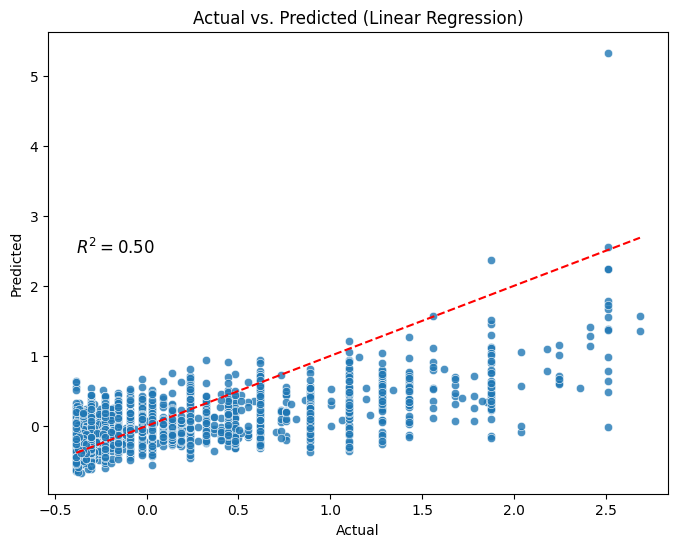

----------------------


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lr = LinearRegression() # to do - settings hyperparameters 
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
residuals_lr = y_test - y_pred_lr

(r2_lr, mae_lr, mse_lr, coefficients_lr, intercept_lr) = get_results(lr, y_test, y_pred_lr)

# Results - Another option would be to use statsmodels to display a summary
print("---------MLR----------")
print_results(r2_lr, mae_lr, mse_lr, coefficients_lr, intercept_lr)
plotRegression(y_pred_lr, r2_lr, 'Linear Regression')
print("----------------------")

### Lasso Regression

---------LASSO----------
R-squared score: 0.0050
Mean Absolute Error: 0.27546187522614746
Mean Squared Error: 0.18093335069258049
Coefficients: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.
  0.          0.          0.         -0.00015448  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
Intercept: -0.12569878120827602
------------------------
---------LASSO CV BEST----------
R-squared score: 0.4902
Mean Absolute Error: 0.1870998903408478
Mean Squared Error: 0.09271636404302167
Coefficients: [-4.43928675e-04  8.10169938e-03  9.28989271e-03  0.00000000e+00
  2.24547034e-02  3.58710302e-02  3.47166606e-03  0.00000000e+00
  4.34747804e-03 -2.58207933e-05  1.67300008e-03 -1.14196740e-02
  1.55946271e-01  3.16098038e-02  2.21873756e-03  1.54448249e-04
  8.77290506e-03  0.00000000e+00  0.00000000e+00  3.04083041e-03
 -0.00000000e+00 -0.00000000e+00  3.03908328e-02 

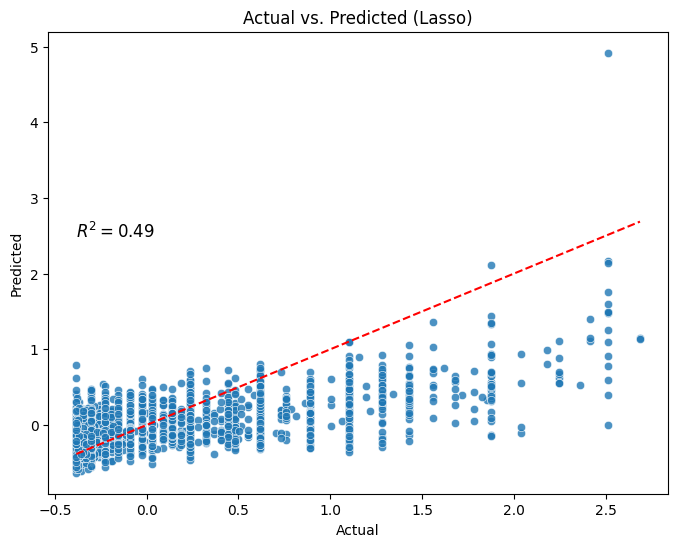

---------------------------


In [17]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Need to scale before using Lasso. I am not sure if we've already done in preprocessing
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

# Lasso Model 1 = basic

lasso = Lasso(tol=0.05)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
(r2_lasso, mae_lasso, mse_lasso, coefficients_lasso, intercept_lasso) = get_results(lasso, y_test, y_pred_lasso)

print("---------LASSO----------")
print_results(r2_lasso, mae_lasso, mse_lasso, coefficients_lasso, intercept_lasso)
print("------------------------")

# Lasso Model 2 = Testing different parameters (CROSS-VALIDATOR: CV)

param_grid = {
	'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]	
}

lasso_cv = GridSearchCV(lasso, param_grid, cv=3, n_jobs=-1)
lasso_cv.fit(X_train, y_train)

# Get the Lasso with the best estimators
lasso_best = lasso_cv.best_estimator_
y_pred_lasso_best = lasso_best.predict(X_test)
(r2_lasso_best, mae_lasso_best, mse_lasso_best, coefficients_lasso_best, intercept_lasso_best) = get_results(lasso_best, y_test, y_pred_lasso_best)

print("---------LASSO CV BEST----------")
print_results(r2_lasso_best, mae_lasso_best, mse_lasso_best, coefficients_lasso_best, intercept_lasso_best)
plotRegression(y_pred_lasso_best, r2_lasso_best, 'Lasso')
print("---------------------------")

### ElasticNet

---------ELASTIC NET BASIC----------
R-squared score: 0.0171
Mean Absolute Error: 0.27223163393691796
Mean Squared Error: 0.1787360446760427
Coefficients: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.0002938   0.00080467 -0.
  0.          0.          0.         -0.00037746  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
Intercept: -0.15707875966865387
---------------------------
---------ELASTIC BEST CV----------
R-squared score: 0.4860
Mean Absolute Error: 0.18796568279373058
Mean Squared Error: 0.093463413322066
Coefficients: [-0.00048634  0.00809941  0.01017923  0.          0.02228831  0.03673514
  0.00300404  0.          0.00388058 -0.          0.00164354 -0.01265215
  0.07739217  0.09686308  0.00227374  0.00013964  0.00880723  0.
  0.          0.0034091  -0.         -0.          0.0298837   0.01514389
  0.01838877]
Intercept: -0.51930000625453


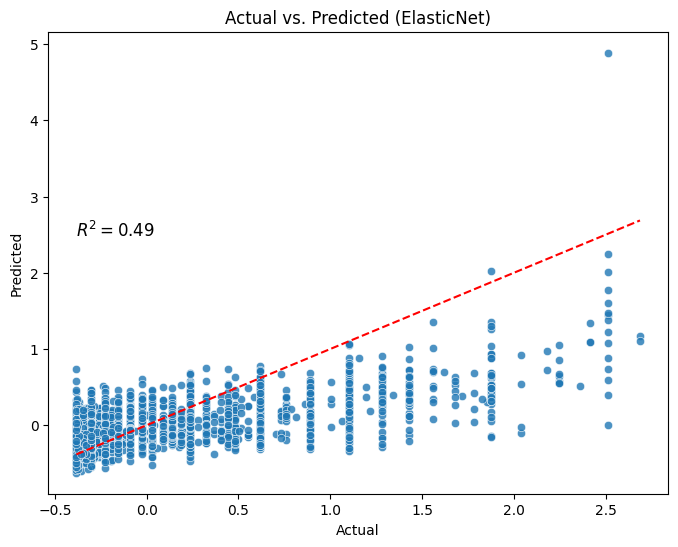

---------------------------


In [18]:
from sklearn.linear_model import ElasticNet

# X_train and X_test should be scaled

# ElasticNet Model 1 = basic

elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)

y_pred_elastic_net = elastic_net.predict(X_test)

(r2_elastic_net, mae_elastic_net, mse_elastic_net, coefficients_elastic_net, intercept_elastic_net) = get_results(elastic_net, y_test, y_pred_elastic_net)

print("---------ELASTIC NET BASIC----------")
print_results(r2_elastic_net, mae_elastic_net, mse_elastic_net, coefficients_elastic_net, intercept_elastic_net)
print("---------------------------")

# ElasticNet Model 2 = Testing different parameters (CROSS-VALIDATOR: CV)

param_grid = {
	'alpha': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],	
	'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0], 	
}

elastic_cv = GridSearchCV(elastic_net, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
elastic_cv.fit(X_train, y_train)

# Get the Elastic with the best estimators
elastic_best = elastic_cv.best_estimator_
y_pred_elastic_best = elastic_best.predict(X_test)
(r2_elastic_best, mae_elastic_best, mse_elastic_best, coefficients_elastic_best, intercept_elastic_best) = get_results(elastic_best, y_test, y_pred_elastic_best)

print("---------ELASTIC BEST CV----------")
print_results(r2_elastic_best, mae_elastic_best, mse_elastic_best, coefficients_elastic_best, intercept_elastic_best)
plotRegression(y_pred_elastic_best, r2_elastic_best, 'ElasticNet')
print("---------------------------")




### XGBRegressor

Fitting 5 folds for each of 180 candidates, totalling 900 fits
R-squared score: 0.6583
Mean Absolute Error: 0.13951366645057664
Mean Squared Error: 0.06213834505077028


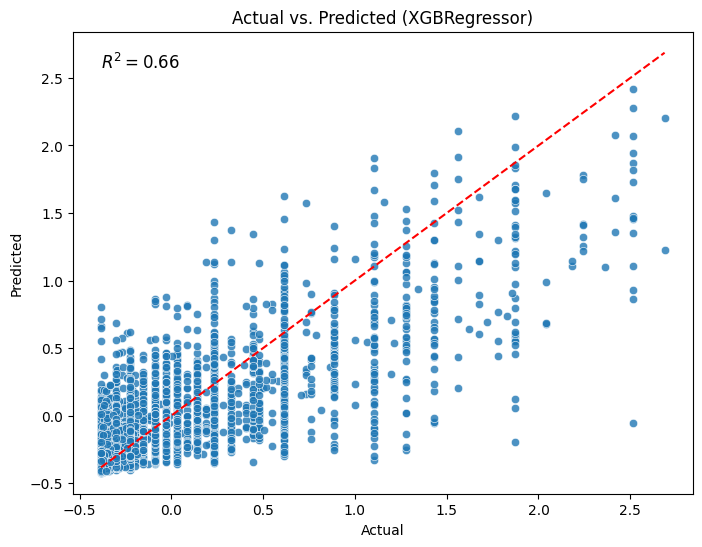

In [19]:
import multiprocessing
import xgboost as xgb

# Initialize XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
    n_jobs=-1, tree_method="hist"
)

# XGB Hyperparamters hav been tuned using this CV param grid.
# Not including parameters 'subsample' or 'colsample_bytree' due to resource usage.
param_grid = {"max_depth": [2, 4, 6], 
              "n_estimators": [50, 100, 200],
              'gamma': [0, 0.1, 0.2, 0.3, 0.4],
              'learning_rate': [0.05, 0.1, 0.2, 0.3]}

# Cross validate model. Find the best hyperparamters using the grid above
xgb_cv = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    verbose=1,
    n_jobs=2
)

# fit model
xgb_cv.fit(X_train, y_train)

# Predict on the test data
xgb_y_pred = xgb_cv.predict(X_test)


xgb_r2 = r2_score(y_test, xgb_y_pred)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
xgb_mse = mean_squared_error(y_test, xgb_y_pred)

print(f"R-squared score: {xgb_r2:.4f}")
print(f"Mean Absolute Error: {xgb_mae}")
print(f"Mean Squared Error: {xgb_mse}")
plotRegression(xgb_y_pred, xgb_r2, 'XGBRegressor')

### Huber Regression

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'huberregressor__alpha': 0.01, 'huberregressor__epsilon': 2.0, 'huberregressor__max_iter': 100, 'huberregressor__warm_start': True}
Best cross-validation score: 0.42
---------HUBER REGRESSOR----------
R-squared score: 0.4838
Mean Absolute Error: 0.1766807350867264
Mean Squared Error: 0.09386952742183353
Coefficients: [-0.01628126  0.01354979  0.01293677  0.00097016  0.02610778  0.05908735
  0.01298446 -0.00155614  0.00959711 -0.00353329  0.05522428 -0.00727423
  0.18203546  0.03011462  0.00966956  0.02905841  0.01412593  0.00114134
 -0.00779051  0.00840947  0.00515591 -0.00992735  0.03498796  0.03123108
  0.05556634]
Intercept: -0.1805746186842581


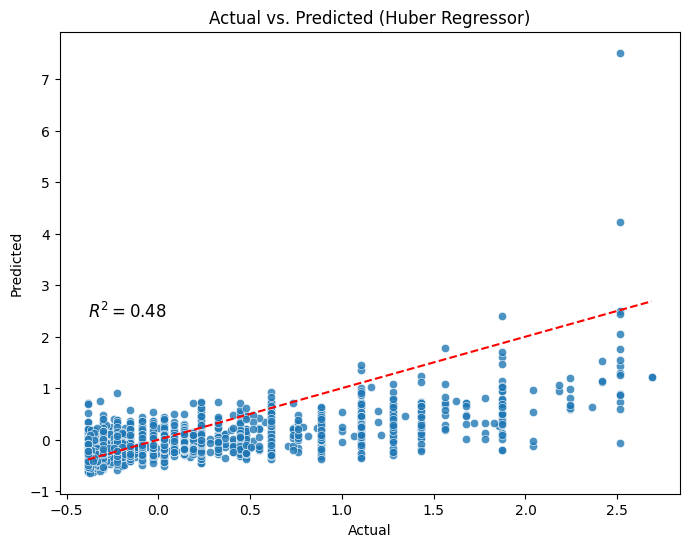

----------------------------------


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline setup with scaler and model for GridSearchCV
pipeline = make_pipeline(StandardScaler(), HuberRegressor())

# Parameter grid
param_grid = {
    'huberregressor__epsilon': [1.35, 1.5, 2.0],
    'huberregressor__max_iter': [100, 500, 1000],
    'huberregressor__alpha': [0.0001, 0.001, 0.01, 0.1],
    'huberregressor__warm_start': [True, False]
}

# GridSearchCV setup
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model parameters from GridSearchCV
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Using best parameters to fit Huber regressor on scaled data
best_params = grid_search.best_params_
huber = HuberRegressor(
    epsilon=best_params['huberregressor__epsilon'],
    max_iter=best_params['huberregressor__max_iter'],
    alpha=best_params['huberregressor__alpha'],
    warm_start=best_params['huberregressor__warm_start']
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
huber.fit(X_train_scaled, y_train)
y_pred_huber = huber.predict(X_test_scaled)  

# Get results using the helper function
(r2_huber, mae_huber, mse_huber, coefficients_huber, intercept_huber) = get_results(huber, y_test, y_pred_huber)

print("---------HUBER REGRESSOR----------")
print_results(r2_huber, mae_huber, mse_huber, coefficients_huber, intercept_huber)

# Function to plot regression results
def plotRegression(y_test, y_pred, r2, modelName=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.8)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')
    plt.title(f'Actual vs. Predicted ({modelName})')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.text(y_test.min(), y_test.max(), f'$R^2 = {r2:.2f}$', fontsize=12, verticalalignment='top')
    plt.show()

plotRegression(y_test, y_pred_huber, r2_huber, 'Huber Regressor')
print("----------------------------------")

### Random Forest Regressor

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation score: 0.62
---------RANDOM FOREST REGRESSOR----------
R-squared score: 0.6498
Mean Absolute Error: 0.13908100480770472
Mean Squared Error: 0.0636864290950335
Coefficients: [0.02638279 0.0141822  0.00337918 0.0004981  0.09077129 0.07939057
 0.00592247 0.00727853 0.00955331 0.01731108 0.02267189 0.00167844
 0.23794813 0.25821189 0.01933802 0.04249731 0.00406093 0.00608568
 0.00725488 0.01390497 0.00424855 0.00196571 0.02091952 0.00091304
 0.10363149]
Intercept: 0


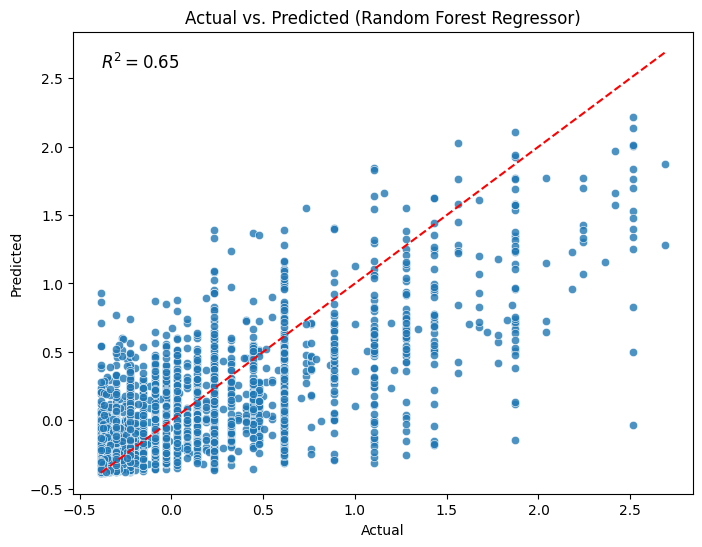

----------------------------------


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# RandomForestRegressor with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]
}

# Create the RandomForestRegressor within a GridSearchCV to optimize the parameters
rf = RandomForestRegressor(random_state=12) 
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Output the best parameters and the best score from the grid search
print("Best parameters:", grid_search_rf.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_rf.best_score_))

# Fit the best model from the grid search
rf_best = grid_search_rf.best_estimator_
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)

# Get results using helper function
r2_rf = rf_best.score(X_test, y_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("---------RANDOM FOREST REGRESSOR----------")
print_results(r2_rf, mae_rf, mse_rf, rf_best.feature_importances_, rf_best.intercept_ if hasattr(rf_best, 'intercept_') else 0)

# Function to plot regression results
plotRegression(y_test, y_pred_rf, r2_rf, 'Random Forest Regressor')
print("----------------------------------")


### MLP REGRESSOR

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'mlpregressor__activation': 'tanh', 'mlpregressor__alpha': 0.01, 'mlpregressor__hidden_layer_sizes': (50,), 'mlpregressor__learning_rate_init': 0.001}
Best cross-validation score: 0.55
---------MLP REGRESSOR----------
R-squared score: 0.5995
Mean Absolute Error: 0.16416604035858887
Mean Squared Error: 0.07282769744244008
Coefficients: []
Intercept: 0


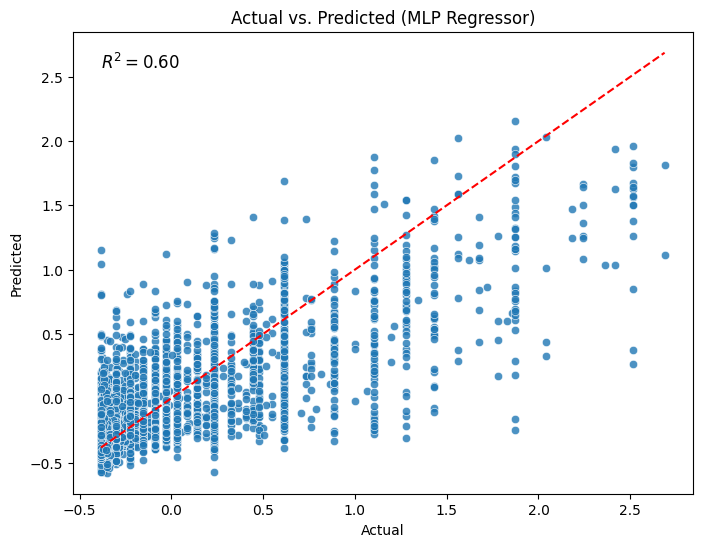

----------------------------------


In [23]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline setup with scaler and MLPRegressor
pipeline = make_pipeline(StandardScaler(), MLPRegressor(random_state=12))

# Parameter grid for GridSearchCV
param_grid = {
    'mlpregressor__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlpregressor__activation': ['relu', 'tanh'],
    'mlpregressor__alpha': [0.0001, 0.001, 0.01],
    'mlpregressor__learning_rate_init': [0.001, 0.01]
}

# GridSearchCV initialization
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model parameters from GridSearchCV
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Fit the best model from the grid search
mlp_best = grid_search.best_estimator_
mlp_best.fit(X_train, y_train)
y_pred_mlp = mlp_best.predict(X_test)

# Get results using helper function
r2_mlp = mlp_best.score(X_test, y_test)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)

print("---------MLP REGRESSOR----------")
print_results(r2_mlp, mae_mlp, mse_mlp, [], 0)  

# Function to plot regression results
def plotRegression(y_test, y_pred, r2, modelName=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.8)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')
    plt.title(f'Actual vs. Predicted ({modelName})')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.text(y_test.min(), y_test.max(), f'$R^2 = {r2:.2f}$', fontsize=12, verticalalignment='top')
    plt.show()

plotRegression(y_test, y_pred_mlp, r2_mlp, 'MLP Regressor')
print("----------------------------------")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
New best parameters: {'mlpregressor__activation': 'tanh', 'mlpregressor__alpha': 0.02, 'mlpregressor__batch_size': 32, 'mlpregressor__hidden_layer_sizes': (100, 50), 'mlpregressor__learning_rate_init': 0.001}
New best cross-validation score: 0.57
---------NEW MLP REGRESSOR----------
R-squared score: 0.6015
Mean Absolute Error: 0.15476399193704082
Mean Squared Error: 0.07247009265679238
Coefficients: []
Intercept: 0


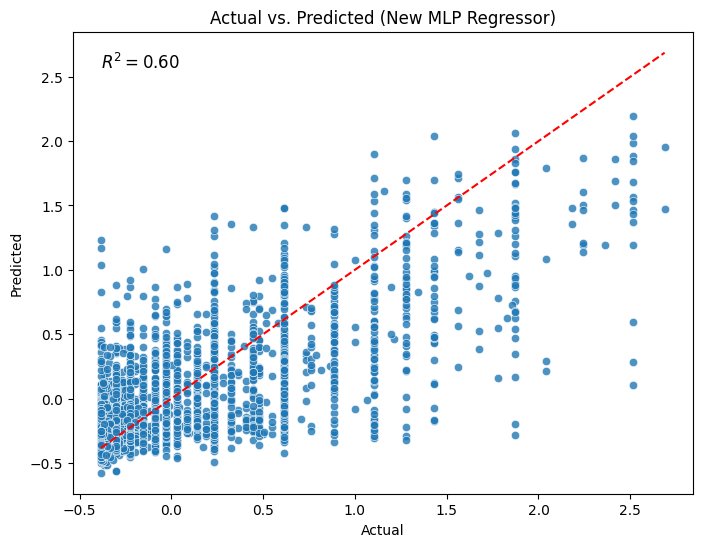

----------------------------------


In [24]:
from sklearn.base import clone

mlp_best = clone(grid_search.best_estimator_)

# Expanding parameter grid based on initial findings
new_param_grid = {
    'mlpregressor__hidden_layer_sizes': [(100,), (50, 50), (100, 50), (50, 50, 50)],
    'mlpregressor__activation': ['tanh', 'relu'],
    'mlpregressor__alpha': [0.005, 0.01, 0.02],
    'mlpregressor__learning_rate_init': [0.0005, 0.001, 0.005],
    'mlpregressor__batch_size': [32, 64, 128]
}

# New GridSearchCV to refine the model further
new_grid_search = GridSearchCV(mlp_best, new_param_grid, cv=5, verbose=1, n_jobs=-1)
new_grid_search.fit(X_train, y_train)

# Output the best parameters and the best score from the new grid search
print("New best parameters:", new_grid_search.best_params_)
print("New best cross-validation score: {:.2f}".format(new_grid_search.best_score_))

# Fit the best model from the new grid search
new_mlp_best = new_grid_search.best_estimator_
new_mlp_best.fit(X_train, y_train)
new_y_pred_mlp = new_mlp_best.predict(X_test)

# Get new results using helper function
new_r2_mlp = new_mlp_best.score(X_test, y_test)
new_mae_mlp = mean_absolute_error(y_test, new_y_pred_mlp)
new_mse_mlp = mean_squared_error(y_test, new_y_pred_mlp)

print("---------NEW MLP REGRESSOR----------")
print_results(new_r2_mlp, new_mae_mlp, new_mse_mlp, [], 0) 
plotRegression(y_test, new_y_pred_mlp, new_r2_mlp, 'New MLP Regressor')
print("----------------------------------")


### Model Evaluation Comparison 

In [ ]:
# WIP

### Conclusion and Insights

#### Key Findings

#### Implications